In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.analysis_tools.analysis as an


#from scipy.optimize import curve_fit


main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/hydraulic/'

In [2]:
def calc_mu(theta) :
    return np.sin(theta)**2 / (2*theta - np.sin(2*theta))

def calc_chi(theta, gamma, kappa, ell0, L0) :
    mu = calc_mu(theta)
    return 0.5*mu*np.sin(theta)*gamma*kappa / (ell0*L0**3)
    #return gamma*kappa / (ell0*L0**3)

def calc_chi(theta, eps, kappa, ell0, L0) :
    mu = calc_mu(theta)
    return 0.5*mu*np.sin(theta)*eps*kappa / (ell0*L0**3)
    #return mu*np.sin(theta)*eps / (L0*ell0**3)


def lin(x, a, b) :
    return a*x+b

def fit_lin(t, N) :
    x, y = np.log(t), np.log(N)
    popt, pcov = curve_fit(lin, x, y)
    alpha, kappa = popt[0], np.exp(popt[1])
    alpha_std, kappa_std = pcov[0, 0], np.exp(pcov[1, 1])
    return kappa, alpha#, kappa_std, alpha_std
    

In [3]:
def plot_pumping(ca, path_list, plot_param_list, Nt_list, Lambdav=1.) :
    label = False
    Nt_list[ca] = {}
    for n in range(nsim) :
        Nt_list[ca][n] = np.loadtxt(os.path.join(path_list[ca][n], 'sim_nlum.dat'))
        if label :
            plt.plot(Nt_list[ca][n][:, 0]/Lambdav, Nt_list[ca][n][:, 1], color=plot_param_list[ca][0], marker=plot_param_list[ca][1], markersize=plot_param_list[ca][2], linewidth=plot_param_list[ca][3])
        else :
            label = True
            plt.plot(Nt_list[ca][n][:, 0]/Lambdav, Nt_list[ca][n][:, 1], color=plot_param_list[ca][0], marker=plot_param_list[ca][1], markersize=plot_param_list[ca][2], linewidth=plot_param_list[ca][3], label = r'$\Lambda_v$ = '+ str(ca))
    return Nt_list[ca]



# N(0) = 1000

In [4]:
nsim = 20


In [5]:
Nt_N1000={}

ca_list = ['ca0', 'ca1e-5', 'ca1e-4', 'ca1e-3', 'ca1e-2', 'ca1e-1', 'ca1e0']

for ca in ca_list :
    Nt_N1000[ca] = {}
    for n in range(nsim) :
        Nt_N1000[ca][n] = np.loadtxt(os.path.join(main_dir, 'N1000', 'ell10', ca, 'run'+str(n).zfill(4), 'sim_nlum.dat'))
        

In [6]:
def gen_log_times(tmin, tmax, npts) :
    return np.logspace(np.log10(tmin), np.log10(tmax), npts)

def find_argmins(Nt, log_times) :
    index_array = np.zeros(len(log_times), dtype=int)
    for k in range(len(log_times)) :
        index_array[k] = np.argmin(np.abs(log_times[k]-Nt[:, 0]))
    return index_array

def gen_index_array(Nt, npts) :
    size = len(Nt)
    
    tmin = np.min(Nt[1:, 0])   # skip the first time since t=0
    tmax = np.max(Nt[1:, 0])   # skip the first time since t=0
    
    log_times = gen_log_times(tmin, tmax, npts)
    index_array = find_argmins(Nt, log_times)
    
    return index_array




In [7]:

def plot_conf(ca, Nt, npts=20,  wmin=-6, wmax=3, rescaled=False, rescaled_pumping=False, ell0=10, L0=1, tau=1, show_sim=False) :
    global eta, gamma, e0
    theta = np.pi/3.
    mu = calc_mu(theta=theta)
    
    T = ell0*L0**3#(24/mu*np.sin(theta)) * (eta*ell0*L0**3)/(gamma*e0**3)
    
    if show_sim :
        for n in range(nsim) :
            index_array = gen_index_array(Nt[ca][n], npts)
            if rescaled :
                plt.plot(Nt[ca][n][index_array, 0]*ca, Nt[ca][n][index_array, 1], color = ca_dict[ca][0], marker=ca_dict[ca][1], markersize=ca_dict[ca][2], alpha = 0.1)
            elif rescaled_pumping :
                plt.plot(Nt[ca][n][index_array, 0]*ca, Nt[ca][n][index_array, 1], color = ca_dict[ca][0], marker=ca_dict[ca][1], markersize=ca_dict[ca][2], alpha = 0.1)
            else :
                plt.plot(Nt[ca][n][index_array, 0], Nt[ca][n][index_array, 1], color = ca_dict[ca][0], marker=ca_dict[ca][1], markersize=ca_dict[ca][2], alpha = 0.1)

    res_avg, res_std = an.batch(data_dict=Nt[ca], wmin=wmin, wmax=wmax, nwindow=npts)
    if rescaled and float(ca[2:]) != 0. :
        plt.plot(res_avg[:, 0]*float(ca[2:]), res_avg[:, 1], color = ca_param[ca][0], marker = ca_param[ca][1], markersize = ca_param[ca][2], linestyle = ca_param[ca][3], linewidth = ca_param[ca][4], label = r'$\Lambda_v = ' + str(float(ca[2:])) + '$')
    else :    
        plt.plot(res_avg[:, 0], res_avg[:, 1], color = ca_param[ca][0], marker = ca_param[ca][1], markersize = ca_param[ca][2], linestyle = ca_param[ca][3], linewidth = ca_param[ca][4], label = r'$\Lambda_v = ' + str(float(ca[2:])) + '$')
    
    #N0=1000      
    #Tf = T*N0**(5./2)
    #plt.vlines(x=1/Tf, ymin=1., ymax=N0, linestyle = '--', color=plot_param_list[(chis, chiv)][0])




In [8]:
ms, lw = 6, 2
ca_param = {'ca0': ['#FFC400', 'D', ms, '-', lw], 
            'ca1e-5': ['#1800BA', 'o', ms, 'dotted', lw], 
            'ca1e-4': ['#8A00BA', 's', ms, '--', lw], 
            'ca1e-3': ['#4EA3E8', '<', ms, 'dotted', lw], 
            'ca1e-2': ['#FF8300', '>', ms, 'dotted', lw], 
            'ca1e-1': ['#60B42F', 'H', ms, 'dotted', lw], 
            'ca1e0': ['#FF002F', '^', ms, '-.', lw]}

End of import !


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/analysis.py:147: RuntimeWarning: Mean of empty slice
  tavg = np.nanmean([Lavg[j][0] for j in range(len(Lavg))])
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/ana

End of import !


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/analysis.py:147: RuntimeWarning: Mean of empty slice
  tavg = np.nanmean([Lavg[j][0] for j in range(len(Lavg))])
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/ana

End of import !


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/analysis.py:147: RuntimeWarning: Mean of empty slice
  tavg = np.nanmean([Lavg[j][0] for j in range(len(Lavg))])
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/ana

End of import !


/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/analysis.py:147: RuntimeWarning: Mean of empty slice
  tavg = np.nanmean([Lavg[j][0] for j in range(len(Lavg))])
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/ana

End of import !
End of import !


/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/analysis.py:147: RuntimeWarning: Mean of empty slice
  tavg = np.nanmean([Lavg[j][0] for j in range(len(Lavg))])
/Users/mathieuleverge/git/chain_lumen/_ressources/analysis_tools/analysis.py:148: RuntimeWarning: Mean of empty slice
  navg = np.nanmean([Lavg[j][1] for j in range(len(Lavg))])
/usr/local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/l

End of import !


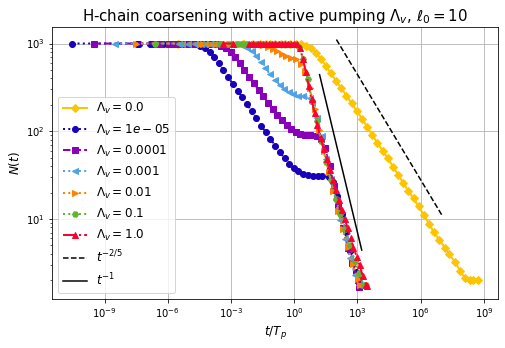

In [9]:
plt.figure(figsize=(8, 5))
plt.xscale('log')
plt.yscale('log')

rescaled = True

npts = 50

plot_conf(ca='ca0', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=9, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-5', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-4', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-3', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-2', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-1', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e0', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=4, rescaled=rescaled, L0=1, tau=1, show_sim=False)


if rescaled : 
    t1 = np.logspace(2, 7, 101)
    k1, a1 = 7000, -2./5
    
    t2 = np.logspace(1.2, 3.2, 101)
    k2, a2 = 7000, -1
else :
    t1 = np.logspace(-3, 3, 101)
    k1, a1 = 20, -2./5

plt.plot(t1, k1*t1**a1, color = 'k', linestyle='--', label = r'$t^{-2/5}$')
plt.plot(t2, k2*t2**a2, color = 'k', linestyle='-', label = r'$t^{-1}$')

plt.grid()
if rescaled :
    plt.xlabel(r'$t/T_p$', fontsize=12)
else :    
    plt.xlabel(r'$t/\tau_v$', fontsize=12)
    
plt.ylabel(r'$N(t)$', fontsize=12)

plt.legend(fontsize=12)
plt.title(r'H-chain coarsening with active pumping $\Lambda_v$, $\ell_0=10$', fontsize=15)
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/H_chain_coarsening_pumping_rescaled.eps', format='eps')
plt.show()



End of import !
End of import !
End of import !
End of import !
End of import !
End of import !
End of import !


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


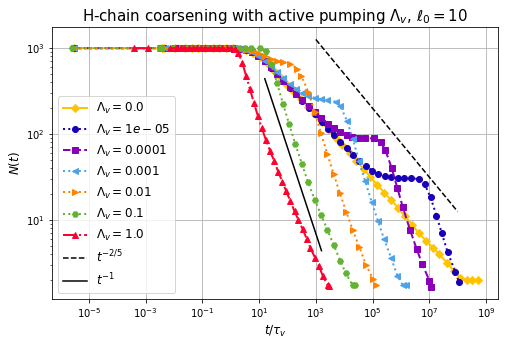

In [10]:
plt.figure(figsize=(8, 5))
plt.xscale('log')
plt.yscale('log')

rescaled = False

npts = 50

plot_conf(ca='ca0', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=9, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-5', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-4', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-3', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-2', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e-1', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=8, rescaled=rescaled, L0=1, tau=1, show_sim=False)
plot_conf(ca='ca1e0', Nt=Nt_N1000, npts=npts,  wmin=-3, wmax=4, rescaled=rescaled, L0=1, tau=1, show_sim=False)


if rescaled : 
    t1 = np.logspace(2, 7, 101)
    k1, a1 = 7000, -2./5
    
    t2 = np.logspace(1.2, 3.2, 101)
    k2, a2 = 7000, -1
else :
    t1 = np.logspace(3, 8, 101)
    k1, a1 = 20000, -2./5
    
    t2 = np.logspace(1.2, 3.2, 101)
    k2, a2 = 7000, -1

plt.plot(t1, k1*t1**a1, color = 'k', linestyle='--', label = r'$t^{-2/5}$')
plt.plot(t2, k2*t2**a2, color = 'k', linestyle='-', label = r'$t^{-1}$')

plt.grid()
if rescaled :
    plt.xlabel(r'$t/T_p$', fontsize=12)
else :    
    plt.xlabel(r'$t/\tau_v$', fontsize=12)
    
plt.ylabel(r'$N(t)$', fontsize=12)

plt.legend(fontsize=12)
plt.title(r'H-chain coarsening with active pumping $\Lambda_v$, $\ell_0=10$', fontsize=15)
plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/H_chain_coarsening_pumping_non_rescaled.eps', format='eps')
plt.show()




NameError: name 'pump1e_4' is not defined

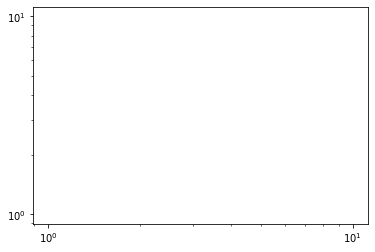

In [10]:
plt.xscale('log')
plt.yscale('log')

ell0 = 10

if pump1e_4 :
    ca = 1e-4
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000, Lambdav=10)

plt.vlines(x=1 , ymin=1, ymax=1000, label = 'T', linestyle = '--')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, label = r'$\Lambda_v^{-1}$', linestyle = '-.')
#plt.vlines(x=1/ca , ymin=1, ymax=1000, label = r'$\ell_0*\Lambda_v^{-1}$', linestyle = 'dotted')
plt.xlabel('time/T')
plt.title(r'H-chain with pumping $\Lambda_v=10^{-4}$, $\ell_0 = 10$')
plt.legend()
plt.show()

In [ ]:
plt.xscale('log')
plt.yscale('log')

ell0 = 100
ca = 1e-4
Nt1000_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000', 'ell100', 'ca1e-4', 'run0001', 'sim_nlum.dat'))

plt.plot(Nt1000_ca1e_4_ell100[:, 0]/ell0, Nt1000_ca1e_4_ell100[:, 1])

plt.vlines(x=1 , ymin=1, ymax=1000, label = 'T', linestyle = '--')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, label = r'$\Lambda_v^{-1}$', linestyle = '-.')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, label = r'$\ell_0*\Lambda_v^{-1}$', linestyle = 'dotted')
plt.xlabel('time/T')
plt.title(r'H-chain with pumping $\Lambda_v=10^{-4}$, $\ell_0 = 100$')
plt.legend()
plt.show()

# Multiple initial lengths
## Coarsening

In [ ]:
plt.xscale('log')
plt.yscale('log')
ca = 1e-4
T = 1.
N0 = 1000
plt.vlines(x=T , ymin=1, ymax=1000, label = 'T', linestyle = '--')

ell0 = 1
Nt1000_ca1e_4_ell1 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1/ca1e-4/run0001/sim_nlum.dat'))
plt.plot(Nt1000_ca1e_4_ell1[:, 0]/ell0, Nt1000_ca1e_4_ell1[:, 1], label = r'$\ell_0=1$', color='blue')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='blue')

ell0 = 10
plt.plot(Nt_list_N1000[ca][0][:, 0]/ell0, Nt_list_N1000[ca][0][:, 1], label = r'$\ell_0=10$', color='purple')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')
#plt.vlines(x=ell0/(ca*ell0) , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')

ell0 = 100
Nt1000_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run0001/sim_nlum.dat'))

plt.plot(Nt1000_ca1e_4_ell100[:, 0]/ell0, Nt1000_ca1e_4_ell100[:, 1], label = r'$\ell_0=100$', color='green')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')
#plt.vlines(x=ell0/(ca*ell0) , ymin=1, ymax=1000, linestyle = 'dotted', color='green')

ell0 = 1000
Nt1000_ca1e_4_ell1000 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1000/ca1e-4/run0001/sim_nlum.dat'))
plt.plot(Nt1000_ca1e_4_ell1000[:, 0]/ell0, Nt1000_ca1e_4_ell1000[:, 1], label = r'$\ell_0=1000$', color='orange')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='orange')

L0 = 1
tm = (2*ca/(2*L0+ell0)**(-5./3)) * T**(-2./3)

#Tp = 1./ca
#plt.vlines(x=Tp , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')
#plt.vlines(x=tm , ymin=1, ymax=1000, linestyle = '-.', color='red')



plt.xlabel(r'$t\gamma / \eta \ell_0 L_0^3$', fontsize=15)
plt.title(r'H-chain with pumping $\Lambda_v='+"{:1.1e}".format(ca)+'$')
plt.legend(fontsize=12)
#plt.xlim(1e3, 1e7)

plt.show()

## Lengths

In [ ]:
step_1e_4_1 = np.argmin(np.abs(Nt1000_ca1e_4_ell1[:, 0] - 1/ca))
step_1e_4_10 = np.argmin(np.abs(Nt_list_N1000[0.0001][0][:, 0] - 1/ca))
step_1e_4_100 = np.argmin(np.abs(Nt1000_ca1e_4_ell100[:, 0] - 1/ca))
step_1e_4_1000 = np.argmin(np.abs(Nt1000_ca1e_4_ell1000[:, 0] - 1/ca))

ellt_ca1e_1 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1/ca1e-4/run0001/sim_ell_avg.dat'))
ellt_ca1e_10 = np.loadtxt(os.path.join(path_list_N1000[ca][1], 'sim_ell_avg.dat'))
ellt_ca1e_100 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run0001/sim_ell_avg.dat'))
ellt_ca1e_1000 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1000/ca1e-4/run0001/sim_ell_avg.dat'))

plt.xscale('log')
plt.yscale('log')

ell1 = 1
ell10 = 1
ell100 = 1
ell1000 = 1

if ell1 : 
    ell0 = 1
    plt.plot(ellt_ca1e_1[:-10, 0]/ell0, ellt_ca1e_1[:-10, 1], color = 'blue', label='$\ell(0)=1$')
    plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='blue')
    ellt_Lv_1 = ellt_ca1e_1[step_1e_4_1, 1]

if ell10 : 
    ell0 = 10
    plt.plot(ellt_ca1e_10[:-10, 0]/ell0, ellt_ca1e_10[:-10, 1], color = 'purple', label='$\ell(0)=10$')
    plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')
    ellt_Lv_10 = ellt_ca1e_10[step_1e_4_10, 1]
    #plt.hlines(xmin=1e-4 , xmax=1e4, y=ellt_Lv_10, linestyle = '-', color='purple')
    #print('ell(0)=10 ; ell(1/Lambda_v) = '+ "{:2.2e}".format(ellt_Lv_10))
    
if ell100 :
    ell0 = 100
    plt.plot(ellt_ca1e_100[:-10, 0]/ell0, ellt_ca1e_100[:-10, 1], color = 'g', label='$\ell(0)=100$')
    plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')
    ellt_Lv_100 = ellt_ca1e_100[step_1e_4_100, 1]
    #plt.hlines(xmin=1e-4 , xmax=1e4, y=ellt_Lv_100, linestyle = '-', color='green')
    #print('ell(0)=100 ; ell(1/Lambda_v) = ', "{:2.2e}".format(ellt_Lv_100))
    
    k100, a100 = 10, 0.37
    t100 = np.logspace(0, 3, 101)
    plt.plot(t100, k100*t100**a100)
    
if ell1000 : 
    ell0 = 1000
    plt.plot(ellt_ca1e_1000[:-10, 0]/ell0, ellt_ca1e_1000[:-10, 1], color = 'orange', label='$\ell(0)=1000$')
    plt.vlines(x=1/(ca*ell0) , ymin=100, ymax=10000, linestyle = '-.', color='orange')
    ellt_Lv_1000 = ellt_ca1e_1000[step_1e_4_1000, 1]
    
#plt.vlines(x=1e4, ymin=1, ymax=1000, color='green', linestyle='dotted')
#plt.vlines(x=3e4, ymin=1, ymax=1000, color='purple', linestyle='dotted')



plt.legend(loc=2)
plt.xlabel('Time')
plt.ylabel(r'$\bar{\ell}(t)$', fontsize=15)
plt.grid()
plt.show()

In [ ]:

step_1e_4_1 = np.argmin(np.abs(Nt1000_ca1e_4_ell1[:, 0] - 1/ca))
step_1e_4_10 = np.argmin(np.abs(Nt_list_N1000[0.0001][0][:, 0] - 1/ca))
step_1e_4_100 = np.argmin(np.abs(Nt1000_ca1e_4_ell100[:, 0] - 1/ca))
step_1e_4_1000 = np.argmin(np.abs(Nt1000_ca1e_4_ell1000[:, 0] - 1/ca))

ellt_ca1e_1 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1/ca1e-4/run0001/sim_ell_avg.dat'))
ellt_ca1e_10 = np.loadtxt(os.path.join(path_list_N1000[ca][1], 'sim_ell_avg.dat'))
ellt_ca1e_100 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run0001/sim_ell_avg.dat'))
ellt_ca1e_1000 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1000/ca1e-4/run0001/sim_ell_avg.dat'))

plt.xscale('log')
plt.yscale('log')

ell1 = 1
ell10 = 1
ell100 = 1
ell1000 = 1

if ell1 : 
    ell0 = 1
    plt.plot(ellt_ca1e_1[:-10, 0]/ell0, ellt_ca1e_1[:-10, 1], color = 'blue', label='$\ell(0)=1$')
    plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='blue')
    ellt_Lv_1 = ellt_ca1e_1[step_1e_4_1, 1]

if ell10 : 
    ell0 = 10
    plt.plot(ellt_ca1e_10[:-10, 0]/ell0, ellt_ca1e_10[:-10, 1], color = 'purple', label='$\ell(0)=10$')
    plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')
    ellt_Lv_10 = ellt_ca1e_10[step_1e_4_10, 1]
    #plt.hlines(xmin=1e-4 , xmax=1e4, y=ellt_Lv_10, linestyle = '-', color='purple')
    #print('ell(0)=10 ; ell(1/Lambda_v) = '+ "{:2.2e}".format(ellt_Lv_10))
    
if ell100 :
    ell0 = 100
    plt.plot(ellt_ca1e_100[:-10, 0]/ell0, ellt_ca1e_100[:-10, 1], color = 'g', label='$\ell(0)=100$')
    plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')
    ellt_Lv_100 = ellt_ca1e_100[step_1e_4_100, 1]
    #plt.hlines(xmin=1e-4 , xmax=1e4, y=ellt_Lv_100, linestyle = '-', color='green')
    #print('ell(0)=100 ; ell(1/Lambda_v) = ', "{:2.2e}".format(ellt_Lv_100))
    
    k100, a100 = 10, 0.37
    t100 = np.logspace(0, 3, 101)
    plt.plot(t100, k100*t100**a100)
    
if ell1000 : 
    ell0 = 1000
    plt.plot(ellt_ca1e_1000[:-10, 0]/ell0, ellt_ca1e_1000[:-10, 1], color = 'orange', label='$\ell(0)=1000$')
    plt.vlines(x=1/(ca*ell0) , ymin=100, ymax=10000, linestyle = '-.', color='orange')
    ellt_Lv_1000 = ellt_ca1e_1000[step_1e_4_1000, 1]
    
#plt.vlines(x=1e4, ymin=1, ymax=1000, color='green', linestyle='dotted')
#plt.vlines(x=3e4, ymin=1, ymax=1000, color='purple', linestyle='dotted')



plt.legend(loc=2)
plt.xlabel(r'$t\gamma / \eta \ell_0 L_0^3$', fontsize=15)
plt.ylabel(r'$\bar{\ell}(t)$', fontsize=15)
plt.grid()
plt.show()

#==========================================================================================
#==========================================================================================
#==========================================================================================

plt.xscale('log')
plt.yscale('log')
ca = 1e-4
T = 1.
N0 = 1000
plt.vlines(x=T , ymin=1, ymax=1000, label = 'T', linestyle = '--')

ell0 = 1
Nt1000_ca1e_4_ell1 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1/ca1e-4/run0001/sim_nlum.dat'))
plt.plot(Nt1000_ca1e_4_ell1[:, 0]/ell0, Nt1000_ca1e_4_ell1[:, 1], label = r'$\ell_0=1$', color='blue')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='blue')

ell0 = 10
plt.plot(Nt_list_N1000[ca][0][:, 0]/ell0, Nt_list_N1000[ca][0][:, 1], label = r'$\ell_0=10$', color='purple')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')
#plt.vlines(x=ell0/(ca*ell0) , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')

ell0 = 100
Nt1000_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run0001/sim_nlum.dat'))

plt.plot(Nt1000_ca1e_4_ell100[:, 0]/ell0, Nt1000_ca1e_4_ell100[:, 1], label = r'$\ell_0=100$', color='green')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')
#plt.vlines(x=ell0/(ca*ell0) , ymin=1, ymax=1000, linestyle = 'dotted', color='green')

ell0 = 1000
Nt1000_ca1e_4_ell1000 = np.loadtxt(os.path.join(main_dir, 'N1000/ell1000/ca1e-4/run0001/sim_nlum.dat'))
plt.plot(Nt1000_ca1e_4_ell1000[:, 0]/ell0, Nt1000_ca1e_4_ell1000[:, 1], label = r'$\ell_0=1000$', color='orange')
plt.vlines(x=1./(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='orange')

L0 = 1
tm = (2*ca/(2*L0+ell0)**(-5./3)) * T**(-2./3)

#Tp = 1./ca
#plt.vlines(x=Tp , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')
#plt.vlines(x=tm , ymin=1, ymax=1000, linestyle = '-.', color='red')


plt.xlabel(r'$t\gamma / \eta \ell_0 L_0^3$', fontsize=15)
plt.title(r'H-chain with pumping $\Lambda_v='+"{:1.1e}".format(ca)+'$')
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Distribution

In [6]:
def find_tstep(time_list, t0) :
    return np.argmin(np.abs(time_list - t0))

def calc_avg_distrib(X_dict, Y_dict) :
    X_array = np.array([X_dict[k] for k in X_dict.keys()])
    X_avg = np.average(X_array, axis=0)

    Y_array = np.array([Y_dict[k] for k in Y_dict.keys()])
    Y_avg = np.average(Y_array, axis=0)
    return X_avg, Y_avg


In [4]:
nsim = 20

In [275]:
Nt_1000_ca1e_4 = {}
Nt_1000_ca1e_3 = {}
for k in range(nsim) :
    Nt_1000_ca1e_4[k] = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run'+str(k).zfill(4), 'sim_nlum.dat'))
    Nt_1000_ca1e_3[k] = np.loadtxt(os.path.join(main_dir, 'N1000/ell100/ca1e-3/run'+str(k).zfill(4), 'sim_nlum.dat'))
    

In [8]:
D_Nt1000_ca1e_4 = {}
T_list = {}

for k in range(nsim) :
    d = open(os.path.join(main_dir, 'N1000/ell100/ca1e-4/run'+str(k).zfill(4)+'/distrib_length.dat'), 'r').readlines()
    D_Nt1000_ca1e_4[k] = [an.distrib(d[i], nbins=30) for i in range(int(len(d)))]
    T_list[k] = np.array([D_Nt1000_ca1e_4[k][i][0] for i in range(len(D_Nt1000_ca1e_4[k]))])
    print(k)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [317]:
def make_T_dict(folder, npts, nsim=20, log_tmin=-3, log_tmax=7) :
    time_plot_list = np.logspace(log_tmin, log_tmax, npts)
    T_dict = {}
    for k in range(nsim) :
        T_dict[k] = np.loadtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), usecols=0)
    return T_dict, time_plot_list

def make_step_dict(T_dict, time_plot_list, npts, nsim) :
    step_dict = {}
    for n in range(npts) :
        step_dict[n] = {}
        for k in range(nsim) :
            step_dict[n][k] = np.argmin(np.abs(T_dict[k] - time_plot_list[n]))
    return step_dict

def plot_distrib2(step, nsim, folder, T_dict, time_plot_list, step_dict, Nt, show_hist=True, savefig=False, savename='pic.png', rescaled=True, extension='png') :
    L = []
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    ax[0].set_xlim(0.1, 1.80)
    ax[0].set_ylim(0., 1.)
    
    for k in range(nsim) :
        try :
            len_sim = len(T_dict[k])       # Length of the sim k
            step_sim = step_dict[step][k]     # Corresponding step for k
            data = np.genfromtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), skip_header=step_sim, skip_footer=len_sim-step_sim-1)
            t_sim, lengths_sim = data[0], data[1:]

            new_bins = np.max([10, int(np.log10(len(lengths_sim)))*10])

            #print(len(lengths_sim), bins, new_bins)

            L += [lengths_sim]
            weights = np.ones_like(lengths_sim)/float(len(lengths_sim))
            if show_hist :
                ax[0].hist(lengths_sim/np.average(lengths_sim), bins=new_bins, label=t_sim, alpha=0.1, weights=weights)

            ax[1].plot(Nt[k][:, 0], Nt[k][:, 1])
            s = np.argmin(np.abs(Nt[k][:,0]-t_sim))
            ax[1].scatter(Nt[k][s, 0], Nt[k][s, 1])
        except :
            pass
        
    new_L = np.concatenate([L[n] for n in range(len(L))])
    weights = np.ones_like(new_L)/float(len(new_L))
    
    y, x = np.histogram(new_L, bins=new_bins, weights=weights)
    
    new_x = 0.5*(x[1:]+x[:-1])
    ax[0].plot(new_x/np.average(new_L), y, color = 'k')
    
    if rescaled :
        ax[0].set_xlabel(r'$L/\bar{L}$', fontsize=12)
    else :
        ax[0].set_xlabel(r'$L$', fontsize=12)
    ax[0].set_ylabel(r'$\phi_L(t)/N(t)$', fontsize=12)
    
    ax[1].set_xlabel(r'Time [s]', fontsize=12)
    ax[1].set_ylabel(r'$N(t)$', fontsize=12)
    
    plt.suptitle('t = '+"{:2.2e}".format(time_plot_list[step]), fontsize=20)
    if savefig :
        plt.savefig(savename, format = extension)
        plt.close()
    else :
        plt.show()
    

# $c_a = 10^{-4}$

In [319]:
npts = 101
nsim = 20
folder = os.path.join(main_dir, 'N1000/ell100/ca1e-4/')

T_dict, time_plot_list = make_T_dict(folder = folder, npts=npts, nsim=nsim, log_tmin=0, log_tmax=7)
step_dict = make_step_dict(T_dict, time_plot_list, npts, nsim)


In [333]:

step=78
show_hist = True
folder = os.path.join(main_dir, 'N1000/ell100/ca1e-4/')
folder2 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/'
savename = os.path.join(folder2, 'pic'+str(step).zfill(4)+'.eps')
plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_4, show_hist=show_hist, savefig=True, savename=savename, rescaled=True, extension='eps')




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [312]:
make_movie=False

if make_movie :
    for n in range(npts) :
        step=n

        show_hist = True
        folder = os.path.join(main_dir, 'N1000/ell100/ca1e-4/')
        folder2 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/pumping_distribution_ca1e-4_rescaled/'
        savename = os.path.join(folder2, 'pic'+str(n).zfill(4)+'.png')
        plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_4, show_hist=show_hist, savefig=True, savename=savename, rescaled=True)



## Multiple distributions

In [334]:
steps = {'A' : [5, [1, 0]], 
         'B' : [40, [2, 0]], 
         'C' : [65, [3, 0]], 
         'D' : [78, [1, 1]], 
         'E' : [85, [2, 1]], 
         'F' : [90, [3, 1]]}

In [351]:
def plot_distrib3(steps, nsim, folder, T_dict, time_plot_list, step_dict, Nt, show_hist=True, rescaled=True, savefig=False, savename='pics.png', extension='png') :
    
    fig, ax = plt.subplots(4, 2, figsize=(8, 20))
    
    ax[0, 0].set_xscale('log')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_xlabel(r'Time [s]', fontsize=12)
    ax[0, 0].set_ylabel(r'$N(t)$', fontsize=12)


    for index in steps.keys() :
        i, j = steps[index][1]
        step = steps[index][0]
        
        ax[i, j].set_xlim(0.1, 1.80)
        ax[i, j].set_ylim(0., 1.)
        
        L = []
        for k in range(nsim) :
            try :
                len_sim = len(T_dict[k])       # Length of the sim k
                step_sim = step_dict[step][k]     # Corresponding step for k
                data = np.genfromtxt(os.path.join(folder, 'run'+str(k).zfill(4)+'/distrib_length.dat'), skip_header=step_sim, skip_footer=len_sim-step_sim-1)
                t_sim, lengths_sim = data[0], data[1:]

                new_bins = np.max([10, int(np.log10(len(lengths_sim)))*10])

                #print(len(lengths_sim), bins, new_bins)

                L += [lengths_sim]
                weights = np.ones_like(lengths_sim)/float(len(lengths_sim))
                if show_hist :
                    ax[i, j].hist(lengths_sim/np.average(lengths_sim), bins=new_bins, label=t_sim, alpha=0.1, weights=weights)

                ax[0, 0].plot(Nt[k][:, 0], Nt[k][:, 1])
                s = np.argmin(np.abs(Nt[k][:,0]-t_sim))
                ax[0, 0].scatter(Nt[k][s, 0], Nt[k][s, 1])
            except :
                pass

        new_L = np.concatenate([L[n] for n in range(len(L))])
        weights = np.ones_like(new_L)/float(len(new_L))

        y, x = np.histogram(new_L, bins=new_bins, weights=weights)

        new_x = 0.5*(x[1:]+x[:-1])
        ax[i, j].plot(new_x/np.average(new_L), y, color = 'k')

        #if rescaled :
        #    ax[i, j].set_xlabel(r'$L/\bar{L}$', fontsize=12)
        #else :
        #    ax[i, j].set_xlabel(r'$L$', fontsize=12)
        #ax[i, j].set_ylabel(r'$\phi_L(t)/N(t)$', fontsize=12)

    if savefig :
        plt.savefig(savename, format = extension)
        plt.close()
    else :
        plt.show()

In [352]:

plot_distrib3(steps=steps, nsim=nsim, folder=os.path.join(main_dir, 'N1000/ell100/ca1e-4/'), T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_4, show_hist=True, rescaled=True, savefig=True, extension='eps', savename='distribution_ca1e-4.eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

# $c_a = 10^{-3}$

In [313]:
npts = 101
nsim = 20
folder = os.path.join(main_dir, 'N1000/ell100/ca1e-3/')

T_dict, time_plot_list = make_T_dict(folder = folder, npts=npts, nsim=nsim, log_tmin=0, log_tmax=6)
step_dict = make_step_dict(T_dict, time_plot_list, npts, nsim)



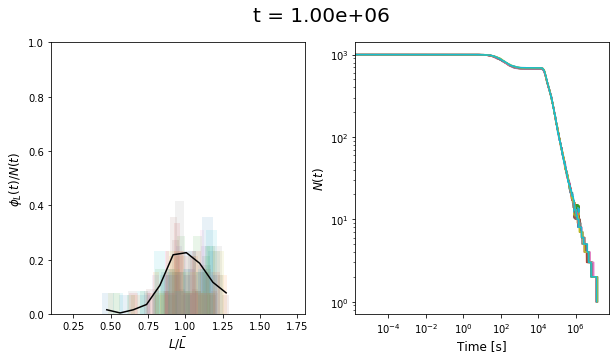

In [314]:
step=100
show_hist = True

folder3 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/pumping_distribution_ca1e-3/'
savename = os.path.join(folder3, 'pic'+str(n).zfill(4)+'.png')
plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_3, show_hist=show_hist, savefig=False, savename=savename, rescaled=True)



In [316]:
make_movie=False

if make_movie :
    for n in range(npts) :
        step=n

        show_hist = True
        folder = os.path.join(main_dir, 'N1000/ell100/ca1e-3/')
        folder2 = '/Users/mathieuleverge/Documents/cavidoc/hydraulic/pumping_distribution_ca1e-3_rescaled/'
        savename = os.path.join(folder2, 'pic'+str(n).zfill(4)+'.png')
        plot_distrib2(step=step, nsim=nsim, folder=folder, T_dict=T_dict, time_plot_list=time_plot_list, step_dict=step_dict, Nt=Nt_1000_ca1e_3, show_hist=show_hist, savefig=True, savename=savename, rescaled=True)




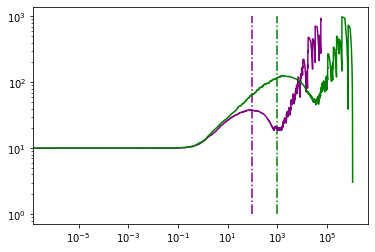

In [17]:

ellt_ca1e_4 = np.genfromtxt(os.path.join('/Users/mathieuleverge/git/chain_lumen/_data/pumping/hydraulic/N1000/ell10/ca1e-4/run0000', 'sim_ell_avg.dat'))
ellt_ca1e_3 = np.genfromtxt(os.path.join('/Users/mathieuleverge/git/chain_lumen/_data/pumping/hydraulic/N1000/ell10/ca1e-3/run0000', 'sim_ell_avg.dat'), skip_footer=2)

plt.xscale('log')
plt.yscale('log')
ell0 = 10
ca = 1e-3
plt.plot(ellt_ca1e_3[:-10, 0]/ell0, ellt_ca1e_3[:-10, 1], color = 'purple')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='purple')

ell0 = 10
ca = 1e-4
plt.plot(ellt_ca1e_4[:-10, 0]/ell0, ellt_ca1e_4[:-10, 1], color = 'g')
plt.vlines(x=1/(ca*ell0) , ymin=1, ymax=1000, linestyle = '-.', color='green')


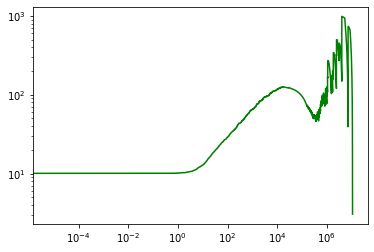

In [20]:
plt.xscale('log')
plt.yscale('log')
plt.plot(ellt_ca1e_4[:-10, 0], ellt_ca1e_4[:-10, 1], color = 'g')




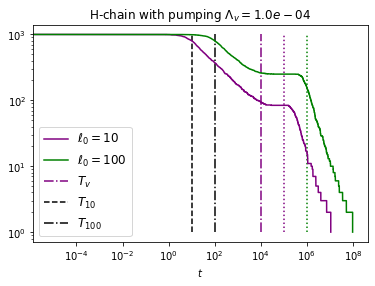

In [170]:
plt.xscale('log')
plt.yscale('log')
ca = 1e-4
#plt.vlines(x=ell0 , ymin=1, ymax=1000, label = 'T', linestyle = '--')

ell0 = 10
plt.plot(Nt_list_N1000[ca][0][:, 0], Nt_list_N1000[ca][0][:, 1], label = r'$\ell_0=10$', color='purple')
plt.vlines(x=1/(ca) , ymin=1, ymax=1000, label = r'$T_{v}$', linestyle = '-.', color='purple')
plt.vlines(x=ell0 , ymin=1, ymax=1000, label = r'$T_{10}$', linestyle = '--')
plt.vlines(x=ell0/(ca) , ymin=1, ymax=1000, linestyle = 'dotted', color='purple')

ell0 = 100
Nt100_ca1e_4_ell100 = np.loadtxt(os.path.join(main_dir, 'N1000', 'ell100', 'ca1e-4', 'run0001', 'sim_nlum.dat'))

plt.plot(Nt100_ca1e_4_ell100[:, 0], Nt100_ca1e_4_ell100[:, 1], label = r'$\ell_0=100$', color='green')
#plt.vlines(x=1/(ca) , ymin=1, ymax=1000, label = r'$T_{v}^{'+str(ell0)+'} = 1/(\Lambda_v)$', linestyle = '-.', color='green')
plt.vlines(x=ell0 , ymin=1, ymax=1000, label = r'$T_{100}$', linestyle = '-.')

plt.vlines(x=ell0/(ca) , ymin=1, ymax=1000, linestyle = 'dotted', color='green')


plt.xlabel(r'$t$')
plt.title(r'H-chain with pumping $\Lambda_v='+"{:1.1e}".format(ca)+'$')
plt.legend(fontsize=12)
plt.show()

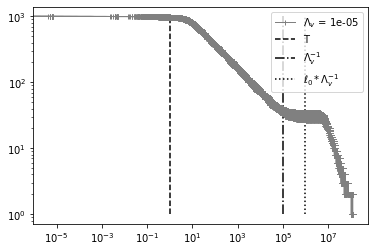

In [49]:
plt.xscale('log')
plt.yscale('log')
if pump1e_5 :
    ca = 1e-5
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

plt.vlines(x=1 , ymin=1, ymax=1000, label = 'T', linestyle = '--')
plt.vlines(x=1/ca , ymin=1, ymax=1000, label = r'$\Lambda_v^{-1}$', linestyle = '-.')
plt.vlines(x=1/ca*10 , ymin=1, ymax=1000, label = r'$\ell_0*\Lambda_v^{-1}$', linestyle = 'dotted')
plt.legend()
plt.show()

# Distribution

In [53]:
Nt = np.loadtxt('/Users/mathieuleverge/git/chain_lumen/_data/pumping/hydraulic/N100/ell10/out0000/sim_nlum.dat')

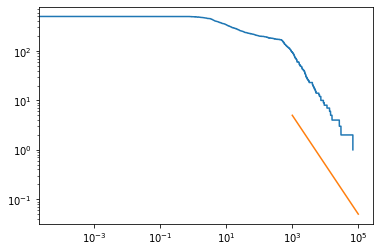

In [56]:
plt.xscale('log')
plt.yscale('log')
plt.plot(Nt[:, 0], Nt[:, 1])

t = np.logspace(3, 5., 101)
k, a = 5000., -1
plt.plot(t, k*t**a)